In [6]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd
from scbasset.utils import *
import pkg_resources
import re

In [41]:
data_path = re.sub('scbasset$', 'data', pkg_resources.resource_filename('scbasset', ''))
filtered_bed_file = '%s/processed/peaks.bed'%data_path # path to save the filtered peak atlas
ad_file = '%s/processed/ad_atac.h5ad'%data_path
h5_file ='%s/processed/train_test_val.h5'%data_path

os.makedirs("results", exist_ok=True)

In [21]:
# read h5ad file
ad = anndata.read_h5ad(ad_file)

# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights('%s/trained_model/best_model.h5'%data_path)

### intercept vs. depth

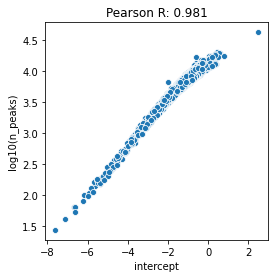

In [23]:
intercept = get_intercept(model) # get_intercept function

f, ax = plt.subplots(figsize=(4,4))
r = scipy.stats.pearsonr(intercept, np.log10(ad.obs['n_genes']))[0]
sns.scatterplot(intercept, np.log10(ad.obs['n_genes']), ax=ax)
ax.set_xlabel('intercept')
ax.set_ylabel('log10(n_peaks)')
ax.set_title('Pearson R: %.3f'%r)
f.savefig('results/intercept.pdf')

### cell embeddings

/home/yuanh/programs/anaconda3/envs/tf2/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


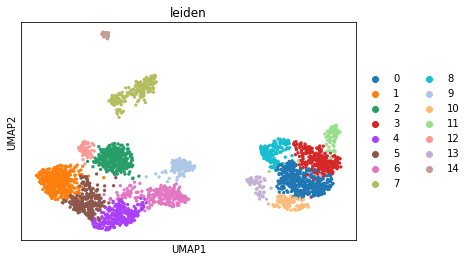

In [34]:
proj = get_cell_embedding(model) # get_cell_embedding function
pd.DataFrame(proj).to_csv('results/projection.csv')

ad.obsm['projection'] = pd.read_csv('results/projection.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color='leiden')

### imputation

In [42]:
f = h5py.File(h5_file, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

Y_norm = imputation_Y_normalize(X, model)